In [1]:
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals

import sys

from itertools import chain
from docopt import docopt
from sumy import __version__
from sumy.utils import ItemsCount, get_stop_words, fetch_url
from sumy.models import TfDocumentModel
from sumy._compat import to_string
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.random import RandomSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.evaluation import precision, recall, f_score, cosine_similarity, unit_overlap
from sumy.evaluation import rouge_1, rouge_2, rouge_l_sentence_level, rouge_l_summary_level 

In [2]:
PARSERS = {
    "html": HtmlParser,
    "plaintext": PlaintextParser,
}

In [3]:
def build_random(parser, language):
    return RandomSummarizer()

def build_luhn(parser, language):
    summarizer = LuhnSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_edmundson(parser, language):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.null_words = get_stop_words(language)
    summarizer.bonus_words = parser.significant_words
    summarizer.stigma_words = parser.stigma_words

    return summarizer

def build_lsa(parser, language):
    summarizer = LsaSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_text_rank(parser, language):
    summarizer = TextRankSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_lex_rank(parser, language):
    summarizer = LexRankSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_sum_basic(parser, language):
    summarizer = SumBasicSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def build_kl(parser, language):
    summarizer = KLSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)

    return summarizer

def evaluate_cosine_similarity(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return cosine_similarity(evaluated_model, reference_model)

def evaluate_unit_overlap(evaluated_sentences, reference_sentences):
    evaluated_words = tuple(chain(*(s.words for s in evaluated_sentences)))
    reference_words = tuple(chain(*(s.words for s in reference_sentences)))
    evaluated_model = TfDocumentModel(evaluated_words)
    reference_model = TfDocumentModel(reference_words)

    return unit_overlap(evaluated_model, reference_model)

In [4]:
AVAILABLE_METHODS = {
    "luhn": build_luhn,
    "edmundson": build_edmundson,
    "lsa": build_lsa,
    "text-rank": build_text_rank,
    "lex-rank": build_lex_rank,
    "sum-basic": build_sum_basic,
    "kl": build_kl,
}

AVAILABLE_EVALUATIONS = (
    ("Precision", False, precision),
    ("Recall", False, recall),
    ("F-score", False, f_score),
    ("Cosine similarity", False, evaluate_cosine_similarity),
    ("Cosine similarity (document)", True, evaluate_cosine_similarity),
    ("Unit overlap", False, evaluate_unit_overlap),
    ("Unit overlap (document)", True, evaluate_unit_overlap),
    ("Rouge-1", False, rouge_1),
    ("Rouge-2", False, rouge_2),
    ("Rouge-L (Sentence Level)", False, rouge_l_sentence_level),
    ("Rouge-L (Summary Level)", False, rouge_l_summary_level)
)

In [5]:
#text = 'From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster debut opposite Shah Rukh Khan in Chaiyya Chaiyya from Dil Se (1998), is still remembered for the song. However, for trolls, she is a woman first and what matters right now is that she divorced a ?rich man?.  On Wednesday, Malaika Arora shared a gorgeous picture of herself on Instagram and a follower decided to troll her for using her ?alumni? (read alimony) money to wear ?short clothes and going to gym or salon?. Little did he/she know that the Munni Badnam star would reply with the perfect comeback. Take a look at the interaction:     Super excited to be affiliated with Khanna Jewellers @khannajewellerskj as their brand ambassador. Crafted to perfection, their stunning statement jewellery is a must have for every jewellery lover. #khannajewellers...#maksquad?? #hair @hairbypriyanka #stylist @manekaharisinghani #manager @ektakauroberoi #mua? @subbu28 #photographer @prasdnaik A post shared by Malaika Arora Khan (@malaikaarorakhanofficial) on Aug 2, 2017 at 6:20am PDT Then, Malaika decided to reply: The entire conversation only proves that no matter if a woman is successful, she will be attacked the moment she decides to step out of bounds the society decided for her. Apart from being a successful woman who lives life on her own terms, Malaika has literally played all the roles traditionally prescribed for a woman - she married quite early, had a son and raised him and was always around with the ?khandan?. But then, she got divorced and alimony is the taunt being thrown at her. The details of the alimony are only known to Malaika, her husband Arbaaz Khan and perhaps the family. The couple has handled the divorce with the utmost dignity. But we can vouch for the fact that she did not  need an alimony to buy clothes (short or not, her choice), go on vacations and enjoy her life. If anything, she is as successful, if not more, than her ex-husband.What happened between Arbaaz and Malaika is their personal concern. But to claim that Malaika married and then divorced Arbaaz for money doesn?t hold water. For those who do not agree, please get a course in feminism and for others, here?s a playlist of some of her most popular songs. Follow @htshowbiz for more'
#reference = 'The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.'

In [6]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd

text_data = pd.read_csv("news_summary.csv", header=None, encoding = "ISO-8859-1")
text_all = text_data[5].values
reference_all = text_data[4].values

for a, b in AVAILABLE_METHODS.items():
    names = "txt2sum_result_"+a+".csv"
    raw_data = {'Precision':[], 'Recall':[], 'F-score':[], 'Cosine similarity':[], 'Cosine similarity (document)':[], 'Unit overlap':[], 'Unit overlap (document)':[], 'Rouge-1':[], 'Rouge-2':[], 'Rouge-L (Sentence Level)':[], 'Rouge-L (Summary Level)':[]}
    columns = [i[0] for i in AVAILABLE_EVALUATIONS]
    df = DataFrame(raw_data, columns = columns)
    for i in range(1, len(text_all)):
        summarizer_builder = b
        parser = PlaintextParser(text_all[i], Tokenizer('english'))
        
        summarizer = summarizer_builder(parser, 'english')
        document = parser.document
        items_count = ItemsCount(2)
        reference_summary = reference_all[i]
        
        try:
            evaluated_sentences = summarizer(document, items_count)
        except:
            continue
        reference_document = PlaintextParser.from_string(reference_summary,Tokenizer("english"))
        reference_sentences = reference_document.document.sentences
        raw_data = {}
        for name, evaluate_document, evaluate in AVAILABLE_EVALUATIONS:
            if evaluate_document:
                result = evaluate(evaluated_sentences, document.sentences)
            else:
                try :
                    result = evaluate(evaluated_sentences, reference_sentences)
                except :
                    break
            raw_data[name]=float(result)
        if(len(raw_data) == 11):
            df.loc[len(df)] = raw_data
    print("================================ "+ a + " done! ==============================")
    df.to_csv(names)

# 알고리즘별 그래프

In [7]:
%matplotlib inline 
import math
import matplotlib.pyplot as plt
import scipy as sp
from pylab import figure, axes, pie, title, savefig

In [8]:
col = [i[0] for i in AVAILABLE_EVALUATIONS]

In [9]:
# luhn
static_luhn = pd.read_csv("txt2sum_result_luhn.csv", header=None, encoding = "ISO-8859-1")
static_luhn = static_luhn.drop(0,0)
static_luhn = static_luhn.drop(0,1)
static_luhn.columns=col
static_luhn[col] = static_luhn[col].astype(float)
static_luhn = static_luhn.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# edmundson
static_edmundson = pd.read_csv("txt2sum_result_edmundson.csv", header=None, encoding = "ISO-8859-1")
static_edmundson = static_edmundson.drop(0,0)
static_edmundson = static_edmundson.drop(0,1)
static_edmundson.columns=col
static_edmundson[col] = static_edmundson[col].astype(float)
static_edmundson = static_edmundson.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lsa
static_lsa = pd.read_csv("txt2sum_result_lsa.csv", header=None, encoding = "ISO-8859-1")
static_lsa = static_lsa.drop(0,0)
static_lsa = static_lsa.drop(0,1)
static_lsa.columns=col
static_lsa[col] = static_lsa[col].astype(float)
static_lsa = static_lsa.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# text-rank
static_text_rank = pd.read_csv("txt2sum_result_text-rank.csv", header=None, encoding = "ISO-8859-1")
static_text_rank = static_text_rank.drop(0,0)
static_text_rank = static_text_rank.drop(0,1)
static_text_rank.columns=col
static_text_rank[col] = static_text_rank[col].astype(float)
static_text_rank = static_text_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lex-rank
static_lex_rank = pd.read_csv("txt2sum_result_lex-rank.csv", header=None, encoding = "ISO-8859-1")
static_lex_rank = static_lex_rank.drop(0,0)
static_lex_rank = static_lex_rank.drop(0,1)
static_lex_rank.columns=col
static_lex_rank[col] = static_lex_rank[col].astype(float)
static_lex_rank = static_lex_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# sum-basic
static_sum_basic = pd.read_csv("txt2sum_result_sum-basic.csv", header=None, encoding = "ISO-8859-1")
static_sum_basic = static_sum_basic.drop(0,0)
static_sum_basic = static_sum_basic.drop(0,1)
static_sum_basic.columns=col
static_sum_basic[col] = static_sum_basic[col].astype(float)
static_sum_basic = static_sum_basic.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

#kl
static_kl = pd.read_csv("txt2sum_result_kl.csv", header=None, encoding = "ISO-8859-1")
static_kl = static_kl.drop(0,0)
static_kl = static_kl.drop(0,1)
static_kl.columns=col
static_kl[col] = static_kl[col].astype(float)
static_kl = static_kl.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

## luhn 그래프

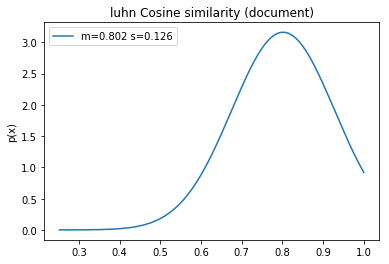

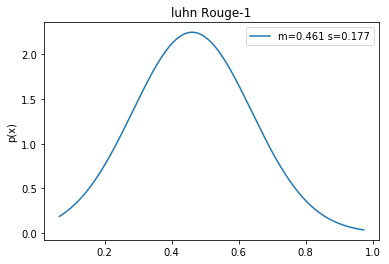

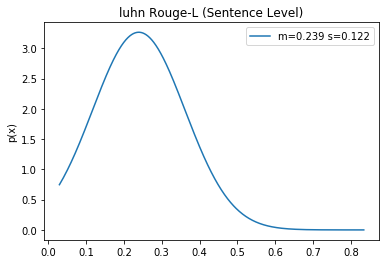

In [10]:
for col in static_luhn.columns:
    x = [i for i in static_luhn.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("luhn " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_luhn_"+col+".png")

## edmundson 그래프

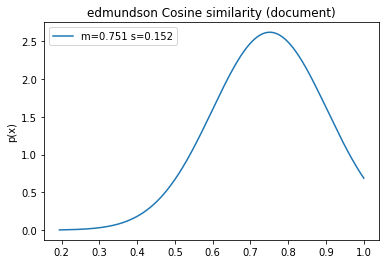

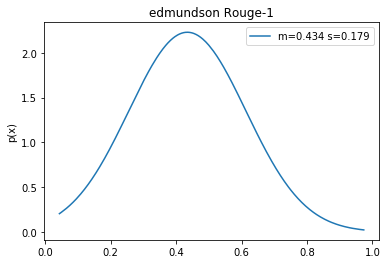

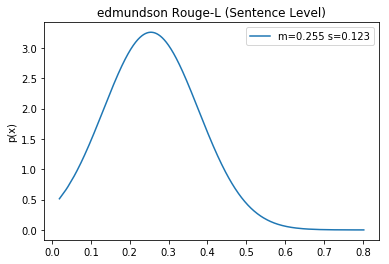

In [11]:
for col in static_edmundson.columns:
    x = [i for i in static_edmundson.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("edmundson " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_edmundson_"+col+".png")

## lsa 그래프

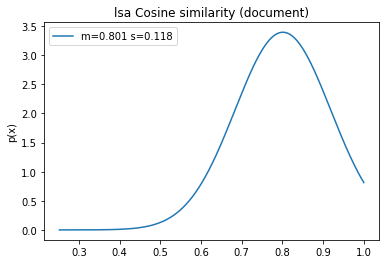

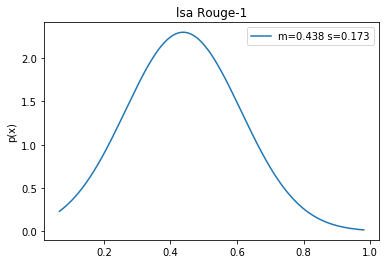

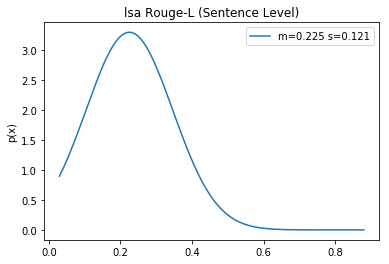

In [12]:
for col in static_lsa.columns:
    x = [i for i in static_lsa.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("lsa " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_lsa_"+col+".png")

## text-rank 그래프

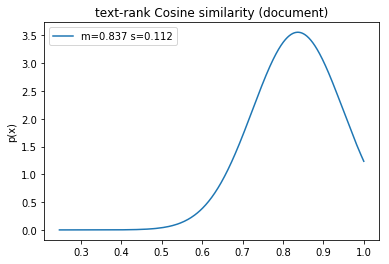

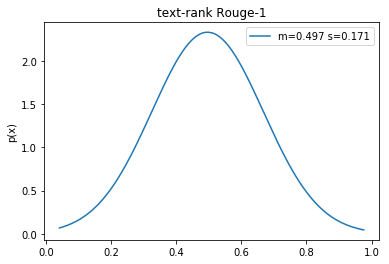

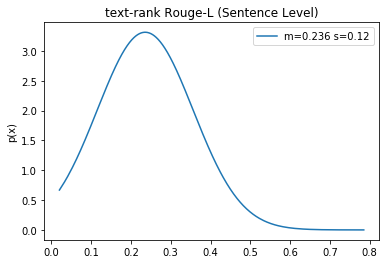

In [13]:
for col in static_text_rank.columns:
    x = [i for i in static_text_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("text-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_text-rank_"+col+".png")

## lex-rank 그래프

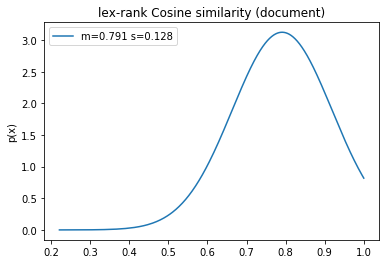

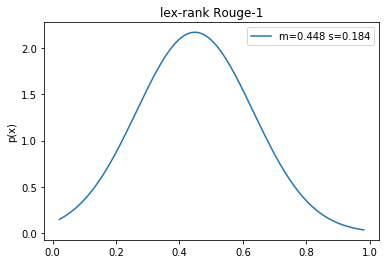

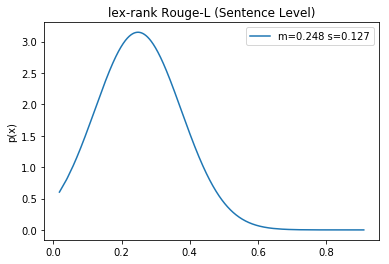

In [14]:
for col in static_lex_rank.columns:
    x = [i for i in static_lex_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("lex-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_lex-rank_"+col+".png")

## sum-basic 그래프

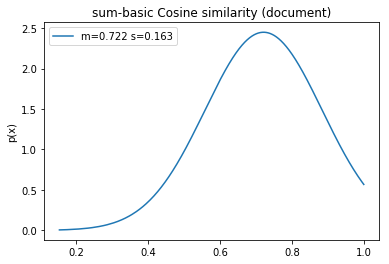

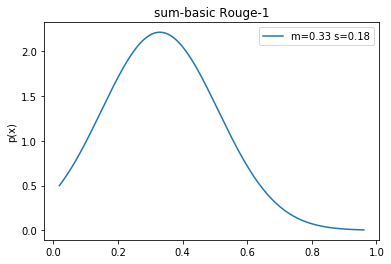

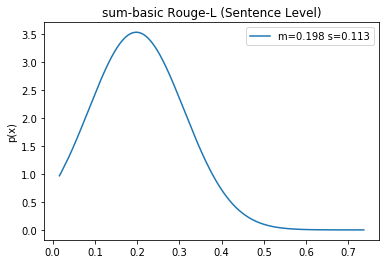

In [15]:
for col in static_sum_basic.columns:
    x = [i for i in static_sum_basic.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("sum-basic " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_sum-basic_"+col+".png")

## kl 그래프

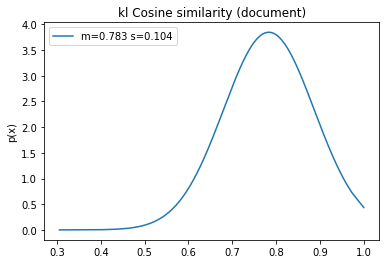

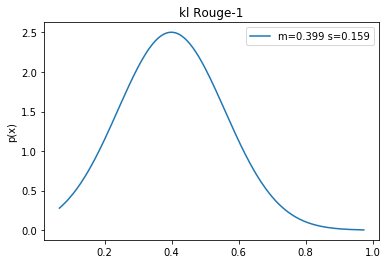

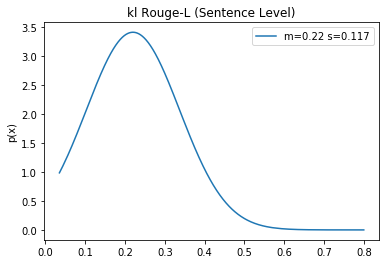

In [16]:
for col in static_kl.columns:
    x = [i for i in static_kl.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kl " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("txt2sum_kl_"+col+".png")

# 한국어

In [17]:
kor_text = pd.read_csv("news_kor.csv",header=None, encoding='utf-8')

In [18]:
kor_reference_all = kor_text[0].values
kor_text_all=kor_text[1].values

In [ ]:
for a, b in AVAILABLE_METHODS.items():
    names = "kor_txt2sum_result_"+a+".csv"
    raw_data = {'Precision':[], 'Recall':[], 'F-score':[], 'Cosine similarity':[], 'Cosine similarity (document)':[], 'Unit overlap':[], 'Unit overlap (document)':[], 'Rouge-1':[], 'Rouge-2':[], 'Rouge-L (Sentence Level)':[], 'Rouge-L (Summary Level)':[]}
    columns = [i[0] for i in AVAILABLE_EVALUATIONS]
    df = DataFrame(raw_data, columns = columns)
    for i in range(1, len(kor_text_all)):
        summarizer_builder = b
        parser = PlaintextParser(kor_text_all[i], Tokenizer('korean'))

        summarizer = summarizer_builder(parser, 'korean')
        document = parser.document
        items_count = ItemsCount(2)
        reference_summary = kor_reference_all[i]
        try:
            evaluated_sentences = summarizer(document, items_count)
        except:
            continue
        reference_document = PlaintextParser.from_string(reference_summary,Tokenizer("korean"))
        reference_sentences = reference_document.document.sentences
        raw_data = {}
        for name, evaluate_document, evaluate in AVAILABLE_EVALUATIONS:
            if evaluate_document:
                result = evaluate(evaluated_sentences, document.sentences)
            else:
                try :
                    result = evaluate(evaluated_sentences, reference_sentences)
                except :
                    break
            raw_data[name]=float(result)
        if(len(raw_data) == 11):
            df.loc[len(df)] = raw_data
    print("================================ "+ a + " done! ==============================")
    df.to_csv(names)

pr_refer: 
 (<Sentence: Union Territory Daman과 Diu 행정부는 8 월 7 일 Rakshabandhan 행사에서 여성들이 rakhis를 남성 동료들과 묶도록 의무화 한 명령을 취소했습니다.>, <Sentence: 행정부는 8 월 7 일에 회람 발행 후 24 시간 이내에 결정을 철회해야했습니다.>, <Sentence: 직원들로부터 박수 치고 소셜 미디어에 휩쓸 렸습니다.>) 
prec_eval:
 (<Sentence: 이와 관련하여 모든 사무실 / 부서는 개방 된 상태로 유지되어야하며, 적절한 축제 장소에서 축제를 축하한다.>, <Sentence: 지난 해 Modi 정부의 여성 장관들은 군인들과 함께 축제를 축하하기 위해 국경 지역으로갔습니다.>) 

numer: 
 (<Sentence: Union Territory Daman과 Diu 행정부는 8 월 7 일 Rakshabandhan 행사에서 여성들이 rakhis를 남성 동료들과 묶도록 의무화 한 명령을 취소했습니다.>, <Sentence: 행정부는 8 월 7 일에 회람 발행 후 24 시간 이내에 결정을 철회해야했습니다.>, <Sentence: 직원들로부터 박수 치고 소셜 미디어에 휩쓸 렸습니다.>) 
denomi: 
 (<Sentence: 이와 관련하여 모든 사무실 / 부서는 개방 된 상태로 유지되어야하며, 적절한 축제 장소에서 축제를 축하한다.>, <Sentence: 지난 해 Modi 정부의 여성 장관들은 군인들과 함께 축제를 축하하기 위해 국경 지역으로갔습니다.>) 

numer: 
 (<Sentence: 이와 관련하여 모든 사무실 / 부서는 개방 된 상태로 유지되어야하며, 적절한 축제 장소에서 축제를 축하한다.>, <Sentence: 지난 해 Modi 정부의 여성 장관들은 군인들과 함께 축제를 축하하기 위해 국경 지역으로갔습니다.>) 
denomi: 
 (<Sentence: Union Territory Daman과 Diu 행정부는 8 월 7 일 Rakshabandhan 

pr_refer: 
 (<Sentence: Maharashtra의 호텔은 침대 린넨 변경에 대한 빈번한 요청과 객실 문을 며칠 동안 방치 한 'Do not disturb'표지판을 포함하여 성 매매의 흔적을 찾아 내기 위해 직원을 훈련시킬 것입니다.>, <Sentence: 직원들이 의심스러운 행동을 경찰에 알리도록하는 Rescue Me라는 휴대 전화 앱이 개발 될 것입니다.>, <Sentence: 이 사업은 Maharashtra 정부의 지원을 받았다.>) 
prec_eval:
 (<Sentence: 이 이니셔티브 뒤에있는 그룹은 또한 의심스러운 행동을 보게되면 호텔 직원이 현지 경찰과 노련한 인신 매매 공무원에게 알리는 데 사용할 수있는 휴대폰 앱 인 Rescue Me를 개발하고 있습니다.>, <Sentence: 이 그룹은 또한 호텔 직원 및 호텔 직원을위한 인신 매매에 관한 교육 모듈을 개발 중이다.>) 

numer: 
 (<Sentence: Maharashtra의 호텔은 침대 린넨 변경에 대한 빈번한 요청과 객실 문을 며칠 동안 방치 한 'Do not disturb'표지판을 포함하여 성 매매의 흔적을 찾아 내기 위해 직원을 훈련시킬 것입니다.>, <Sentence: 직원들이 의심스러운 행동을 경찰에 알리도록하는 Rescue Me라는 휴대 전화 앱이 개발 될 것입니다.>, <Sentence: 이 사업은 Maharashtra 정부의 지원을 받았다.>) 
denomi: 
 (<Sentence: 이 이니셔티브 뒤에있는 그룹은 또한 의심스러운 행동을 보게되면 호텔 직원이 현지 경찰과 노련한 인신 매매 공무원에게 알리는 데 사용할 수있는 휴대폰 앱 인 Rescue Me를 개발하고 있습니다.>, <Sentence: 이 그룹은 또한 호텔 직원 및 호텔 직원을위한 인신 매매에 관한 교육 모듈을 개발 중이다.>) 

numer: 
 (<Sentence: 이 이니셔티브 뒤에있는 그룹은 또한 의심스러운 행동을 보게되면 호텔 직원이 현지 경찰과 노련한 인신 매매 공무원에게 알리는

pr_refer: 
 (<Sentence: 항공기 사고 조사국의 조사에 따르면 파완 한스 헬리콥터가 매우 낮은 고도에서 날아가고있어 2015 년 봄베이 고원 부근에서 충돌 사고가 발생했다.>, <Sentence: 이 보고서는 강사가 낮은 고도를 알고 있음에도 불구하고, 훈련생 조종사가 상황을 관리 할 수 __없다면 헬리콥터를 장악 할 수 없다.>) 
prec_eval:
 (<Sentence: 수요일에 공개 된 조사 보고서에 따르면 주 조종사의 비행 속도가 낮고 다른 조종사는 그것을 깨닫지 못했다고한다.>, <Sentence: 그는 TK Guha 선장에게 조금 늦게 경고했지만, Guha가 상황을 관리 할 수 __없다는 사실을 깨달은 후에도 사무엘은 헬리콥터를 장악하지 않았습니다 .>) 

numer: 
 (<Sentence: 항공기 사고 조사국의 조사에 따르면 파완 한스 헬리콥터가 매우 낮은 고도에서 날아가고있어 2015 년 봄베이 고원 부근에서 충돌 사고가 발생했다.>, <Sentence: 이 보고서는 강사가 낮은 고도를 알고 있음에도 불구하고, 훈련생 조종사가 상황을 관리 할 수 __없다면 헬리콥터를 장악 할 수 없다.>) 
denomi: 
 (<Sentence: 수요일에 공개 된 조사 보고서에 따르면 주 조종사의 비행 속도가 낮고 다른 조종사는 그것을 깨닫지 못했다고한다.>, <Sentence: 그는 TK Guha 선장에게 조금 늦게 경고했지만, Guha가 상황을 관리 할 수 __없다는 사실을 깨달은 후에도 사무엘은 헬리콥터를 장악하지 않았습니다 .>) 

numer: 
 (<Sentence: 수요일에 공개 된 조사 보고서에 따르면 주 조종사의 비행 속도가 낮고 다른 조종사는 그것을 깨닫지 못했다고한다.>, <Sentence: 그는 TK Guha 선장에게 조금 늦게 경고했지만, Guha가 상황을 관리 할 수 __없다는 사실을 깨달은 후에도 사무엘은 헬리콥터를 장악하지 않았습니다 .>) 
denomi: 
 (<Sentence: 항공기 사고 조사국의 조사에 따

pr_refer: 
 (<Sentence: 대법원은 8 월 8 일에 예정되어있는 구자라트 라야 사바 (Gujarat Rajya Sabha) 선거에서 노타 (NOTA)의 행사를 거부했다.>, <Sentence: SC는이 문제가 헌법상의 문제로 제기 될 것이라고 덧붙였다.>, <Sentence: NOTA가 국가 평의회 선거에 적용되는지 여부.>) 
prec_eval:
 (<Sentence: 1 NOTA 옵션을 허용하는 투표 패널 알림.>, <Sentence: 이 청원서는이 옵션의 사용이 1951 년 인민 대표 재판소 법과 1961 년 선거 규칙 집행 규정에 위배된다고 주장했다.>) 

numer: 
 (<Sentence: 대법원은 8 월 8 일에 예정되어있는 구자라트 라야 사바 (Gujarat Rajya Sabha) 선거에서 노타 (NOTA)의 행사를 거부했다.>, <Sentence: SC는이 문제가 헌법상의 문제로 제기 될 것이라고 덧붙였다.>, <Sentence: NOTA가 국가 평의회 선거에 적용되는지 여부.>) 
denomi: 
 (<Sentence: 1 NOTA 옵션을 허용하는 투표 패널 알림.>, <Sentence: 이 청원서는이 옵션의 사용이 1951 년 인민 대표 재판소 법과 1961 년 선거 규칙 집행 규정에 위배된다고 주장했다.>) 

numer: 
 (<Sentence: 1 NOTA 옵션을 허용하는 투표 패널 알림.>, <Sentence: 이 청원서는이 옵션의 사용이 1951 년 인민 대표 재판소 법과 1961 년 선거 규칙 집행 규정에 위배된다고 주장했다.>) 
denomi: 
 (<Sentence: 대법원은 8 월 8 일에 예정되어있는 구자라트 라야 사바 (Gujarat Rajya Sabha) 선거에서 노타 (NOTA)의 행사를 거부했다.>, <Sentence: SC는이 문제가 헌법상의 문제로 제기 될 것이라고 덧붙였다.>, <Sentence: NOTA가 국가 평의회 선거에 적용되는지 여부.>) 

pr_refer: 
 (<Sentence:

pr_refer: 
 (<Sentence: 노르웨이의 반 이민자 그룹은 부르카 (Burqa)를 착용 한 여성 그룹을 위해 여섯 개의 빈 버스 석을 잘못 찍은 사진을보고 추행 당했다.>, <Sentence: 폐쇄 된 페이스 북 그룹 Fedrelandet viktigst (조국 최초)와 공유 된이 게시물은 "우리 나라에서 그들을 내쫓 으라"와 "테러리스트가 될 수있다"와 같은 코멘트를 얻었습니다.>, <Sentence: 그것은 그룹에서 장난으로 공유되었습니다.>) 
prec_eval:
 (<Sentence: 노르웨이의 반 이민자 그룹은 회원들이 부르카 (Burqas)를 착용 한 여성 그룹을 위해 페이스 북 페이지에 게시 된 여섯 개의 빈 버스 좌석의 사진을 틀린 것으로 분명히 비난했다.>, <Sentence: 어떤 비어있는 버스 좌석의 사진이 역겨운 Facebook 그룹에 게시 될 때 일어난다.>) 

numer: 
 (<Sentence: 노르웨이의 반 이민자 그룹은 부르카 (Burqa)를 착용 한 여성 그룹을 위해 여섯 개의 빈 버스 석을 잘못 찍은 사진을보고 추행 당했다.>, <Sentence: 폐쇄 된 페이스 북 그룹 Fedrelandet viktigst (조국 최초)와 공유 된이 게시물은 "우리 나라에서 그들을 내쫓 으라"와 "테러리스트가 될 수있다"와 같은 코멘트를 얻었습니다.>, <Sentence: 그것은 그룹에서 장난으로 공유되었습니다.>) 
denomi: 
 (<Sentence: 노르웨이의 반 이민자 그룹은 회원들이 부르카 (Burqas)를 착용 한 여성 그룹을 위해 페이스 북 페이지에 게시 된 여섯 개의 빈 버스 좌석의 사진을 틀린 것으로 분명히 비난했다.>, <Sentence: 어떤 비어있는 버스 좌석의 사진이 역겨운 Facebook 그룹에 게시 될 때 일어난다.>) 

numer: 
 (<Sentence: 노르웨이의 반 이민자 그룹은 회원들이 부르카 (Burqas)를 착용 한 여성 그룹을 위해 페이스 북 페이지에 게시 된 여섯 개의 빈 버스 좌

pr_refer: 
 (<Sentence: 수사관들은 지난달 미국 공항에서 에어 캐나다 비행이 얼마나 가까운 거리에서 4 대의 비행기에 충돌했는지를 보여주는 그림을 발표했습니다.>, <Sentence: 그 조종사는 실수로 활주로가 아닌 착륙을 중단하기 위해 4 대의 비행기가 주차 된 유도로를 향해 내려갔습니다.>, <Sentence: 수사관들은이 사건이 최악의 항공 재해 중 하나가되는 몇 피트 이내에 들어 왔다고 말했다.>) 
prec_eval:
 (<Sentence: 에어 캐나다 조종사는 옆의 활주로로 유도로를 착각하여 지상에서 단지 59 피트 (18m)까지 제트기를 날아 다른 착륙 시도를하기 전에 끌어 올렸다고 수요일에 발표 된 국가 교통 안전위원회 (NSF)의 정보에 따르면 그 수치는 겨우 사건이 7 월 7 일 심야에 발생했을 때 유도로에 있던 네 대의 비행기.>, <Sentence: 이 시스템은 특히 항공기 조종사에게 드물게 발생하는 유도로에 착륙하기 위해 줄 지어 놓은 비행기를 찾도록 설계되지 않았습니다.>) 

numer: 
 (<Sentence: 수사관들은 지난달 미국 공항에서 에어 캐나다 비행이 얼마나 가까운 거리에서 4 대의 비행기에 충돌했는지를 보여주는 그림을 발표했습니다.>, <Sentence: 그 조종사는 실수로 활주로가 아닌 착륙을 중단하기 위해 4 대의 비행기가 주차 된 유도로를 향해 내려갔습니다.>, <Sentence: 수사관들은이 사건이 최악의 항공 재해 중 하나가되는 몇 피트 이내에 들어 왔다고 말했다.>) 
denomi: 
 (<Sentence: 에어 캐나다 조종사는 옆의 활주로로 유도로를 착각하여 지상에서 단지 59 피트 (18m)까지 제트기를 날아 다른 착륙 시도를하기 전에 끌어 올렸다고 수요일에 발표 된 국가 교통 안전위원회 (NSF)의 정보에 따르면 그 수치는 겨우 사건이 7 월 7 일 심야에 발생했을 때 유도로에 있던 네 대의 비행기.>, <Sentence: 이 시스템은 특히 항공기 조종사에게 드물게 발생하는 유도로에 

pr_refer: 
 (<Sentence: 미 공군은 수요일, 캘리포니아에서 비무장 대륙간 탄도 미사일을 성공적으로 발사했다.>, <Sentence: 이 테스트는 무기 시스템의 준비 성과 효율성을 보여줄 것이라고 관리들은 말했다.>, <Sentence: 이 발사는 북한에 대한 우려로 최근 미국에 도달 할 수있는 범위의 대륙간 탄도 미사일 2 개를 테스트 한 결과 나온 것이다.>) 
prec_eval:
 (<Sentence: 미 공군은 올해 캘리포니아에서 비무장 대륙간 탄도 미사일을 성공적으로 발사했다.>, <Sentence: 미 공군 미사일은 Vandenberg에서 발사되어 정기적으로 비무장 지형 재 탄생 차량을 4,200 마일 (6,800 킬로미터)에 걸쳐 테스트 한 결과, 미 육군의 미사일 발사 테스트에서 무기 시스템의 유효성, 준비성, 정확성이 입증되었다고 밝혔다.>) 

numer: 
 (<Sentence: 미 공군은 수요일, 캘리포니아에서 비무장 대륙간 탄도 미사일을 성공적으로 발사했다.>, <Sentence: 이 테스트는 무기 시스템의 준비 성과 효율성을 보여줄 것이라고 관리들은 말했다.>, <Sentence: 이 발사는 북한에 대한 우려로 최근 미국에 도달 할 수있는 범위의 대륙간 탄도 미사일 2 개를 테스트 한 결과 나온 것이다.>) 
denomi: 
 (<Sentence: 미 공군은 올해 캘리포니아에서 비무장 대륙간 탄도 미사일을 성공적으로 발사했다.>, <Sentence: 미 공군 미사일은 Vandenberg에서 발사되어 정기적으로 비무장 지형 재 탄생 차량을 4,200 마일 (6,800 킬로미터)에 걸쳐 테스트 한 결과, 미 육군의 미사일 발사 테스트에서 무기 시스템의 유효성, 준비성, 정확성이 입증되었다고 밝혔다.>) 

numer: 
 (<Sentence: 미 공군은 올해 캘리포니아에서 비무장 대륙간 탄도 미사일을 성공적으로 발사했다.>, <Sentence: 미 공군 미사일은 Vandenberg에서 발사되어 정기적으로 비무장 지형 재 탄

pr_refer: 
 (<Sentence: Amarnath Yatra 공격의 주창자 인 Abu Ismail은 Abus Dujana를 Lashkar-e-Taiba (LeT)의 카슈미르 부서장으로 대체 할 것으로 알려졌다.>, <Sentence: 두자 나는 남부 카슈미르의 풀와 마 (Pulwama) 지역에서 7 시간의 총격전 끝에 화요일 보안군에 의해 사망했다.>, <Sentence: 특히 지난 달 아마 나트 야 트라에서 8 명의 순례자가 사망하고 18 명이 부상 당했다.>) 
prec_eval:
 (<Sentence: Ismail은 카슈미르 남쪽 Pulwama 지역에서 7 시간의 총격전 끝에 화요일에 보안군에 의해 Dujana가 살해당한 후 LeT의 새로운 카슈미르 부서장이 될 것이다.>, <Sentence: Abu Dujana와의 만남 : Abil Dujana와의 만남 : Jilted lover가 보안군을 LeT 지휘관으로 이끌었다.>) 

numer: 
 (<Sentence: Amarnath Yatra 공격의 주창자 인 Abu Ismail은 Abus Dujana를 Lashkar-e-Taiba (LeT)의 카슈미르 부서장으로 대체 할 것으로 알려졌다.>, <Sentence: 두자 나는 남부 카슈미르의 풀와 마 (Pulwama) 지역에서 7 시간의 총격전 끝에 화요일 보안군에 의해 사망했다.>, <Sentence: 특히 지난 달 아마 나트 야 트라에서 8 명의 순례자가 사망하고 18 명이 부상 당했다.>) 
denomi: 
 (<Sentence: Ismail은 카슈미르 남쪽 Pulwama 지역에서 7 시간의 총격전 끝에 화요일에 보안군에 의해 Dujana가 살해당한 후 LeT의 새로운 카슈미르 부서장이 될 것이다.>, <Sentence: Abu Dujana와의 만남 : Abil Dujana와의 만남 : Jilted lover가 보안군을 LeT 지휘관으로 이끌었다.>) 

numer: 
 (<Sentence: Ismail은 카슈미르 남쪽 Pulwama 지역에서 7

pr_refer: 
 (<Sentence: Ayesha Gulalai 파키스탄 Tehreek-e-Insaf (PTI) 당의 한 여성 국회의원은 Imran Khan 당원이 당내 여성 지도자들을 괴롭 히고 음란 한 문자 메시지를 보내는 것으로 비난했다.>, <Sentence: 구라 라이 대변인은 "내 성실성이 가장 중요하며 내 명예와 존엄성에 관해서는 타협 할 수 없다"고 말했다.>) 
prec_eval:
 (<Sentence: 2013 년 국회에 선출 된 아프가니스탄 국경 부족 지역 여성 국회의원으로부터 선출 된 아야 · 굴라 라이 (Ayesha Gulalai)는 PTI를 그만두기로 결정했다.>, <Sentence: 구라 라이 대변인은 PTI를 중단하겠다는 그녀의 결정은 대법원에 의해 제기 된 칸의 자산에 관한 사건과 아무런 관련이 없다고 말했다.>) 

numer: 
 (<Sentence: Ayesha Gulalai 파키스탄 Tehreek-e-Insaf (PTI) 당의 한 여성 국회의원은 Imran Khan 당원이 당내 여성 지도자들을 괴롭 히고 음란 한 문자 메시지를 보내는 것으로 비난했다.>, <Sentence: 구라 라이 대변인은 "내 성실성이 가장 중요하며 내 명예와 존엄성에 관해서는 타협 할 수 없다"고 말했다.>) 
denomi: 
 (<Sentence: 2013 년 국회에 선출 된 아프가니스탄 국경 부족 지역 여성 국회의원으로부터 선출 된 아야 · 굴라 라이 (Ayesha Gulalai)는 PTI를 그만두기로 결정했다.>, <Sentence: 구라 라이 대변인은 PTI를 중단하겠다는 그녀의 결정은 대법원에 의해 제기 된 칸의 자산에 관한 사건과 아무런 관련이 없다고 말했다.>) 

numer: 
 (<Sentence: 2013 년 국회에 선출 된 아프가니스탄 국경 부족 지역 여성 국회의원으로부터 선출 된 아야 · 굴라 라이 (Ayesha Gulalai)는 PTI를 그만두기로 결정했다.>, <Sentence: 구라 라이 대변인은 PTI를 중단하겠다는

pr_refer: 
 (<Sentence: 린제이 그레이엄 공화당 상원 의원은 도날드 트럼프 미국 대통령이 핵무장 미사일 개발보다는 북한을 파괴하기 위해 전쟁에 나서겠다고 말한 것으로 알려졌다.>, <Sentence: 그래함 총리는 북한의 위협을 해결하기 위해 외교적 접근법을 선호한다고 덧붙여 "북한의 계획과 북한 자체를 파괴하려는 군사적 선택이있다"고 주장했다.>) 
prec_eval:
 (<Sentence: 공화당 상원의 원인 도널드 트럼프 미국 공화당 상원 의원은 북한이 장거리 핵무장 미사일 개발을 허용하기보다 북한을 파괴하기 위해 전쟁에 나설 것이라고 말한 바있다.>, <Sentence: 북한의 계획과 북한 자체를 파괴하라는 군사적 선택이있다.>) 

numer: 
 (<Sentence: 린제이 그레이엄 공화당 상원 의원은 도날드 트럼프 미국 대통령이 핵무장 미사일 개발보다는 북한을 파괴하기 위해 전쟁에 나서겠다고 말한 것으로 알려졌다.>, <Sentence: 그래함 총리는 북한의 위협을 해결하기 위해 외교적 접근법을 선호한다고 덧붙여 "북한의 계획과 북한 자체를 파괴하려는 군사적 선택이있다"고 주장했다.>) 
denomi: 
 (<Sentence: 공화당 상원의 원인 도널드 트럼프 미국 공화당 상원 의원은 북한이 장거리 핵무장 미사일 개발을 허용하기보다 북한을 파괴하기 위해 전쟁에 나설 것이라고 말한 바있다.>, <Sentence: 북한의 계획과 북한 자체를 파괴하라는 군사적 선택이있다.>) 

numer: 
 (<Sentence: 공화당 상원의 원인 도널드 트럼프 미국 공화당 상원 의원은 북한이 장거리 핵무장 미사일 개발을 허용하기보다 북한을 파괴하기 위해 전쟁에 나설 것이라고 말한 바있다.>, <Sentence: 북한의 계획과 북한 자체를 파괴하라는 군사적 선택이있다.>) 
denomi: 
 (<Sentence: 린제이 그레이엄 공화당 상원 의원은 도날드 트럼프 미국 대통령이 핵무장 미사일 개발보다는 북한을 파괴하기 위해 전쟁에 나서겠다고 말한 것

pr_refer: 
 (<Sentence: 화요일 영국 도로변 수리 회사 AA는 2 억 파운드 (약 1,690 crore) 또는 그 가치의 거의 5 분의 1을 잃었습니다.>, <Sentence: 이는 밥 맥켄지 (Bob Mackenzie) 집행 위원장을 해고 한 지 하루 만에 18 % 나 하락한 이후에 나온 것이다.>, <Sentence: 그러나 아들은 "극도로 괴로워하는 정신 건강 문제"를 사임했다고 밝혔다.>) 
prec_eval:
 (<Sentence: 집행 위원장으로서의 역할, 다른 직책에서부터 이사직 및 회사의 직원으로서 총체적인 비행, 길가 수리 회사 대변인은 해고가 개인적인 행위와 관련 있다고 말했지만, 자세한 내용은 밝히지 않았다.>, <Sentence: 이 회사는 최고 경영자 임명을 목표로 집행 위원장의 역할을 분리 할 계획을 이미 발표했습니다.>) 

numer: 
 (<Sentence: 화요일 영국 도로변 수리 회사 AA는 2 억 파운드 (약 1,690 crore) 또는 그 가치의 거의 5 분의 1을 잃었습니다.>, <Sentence: 이는 밥 맥켄지 (Bob Mackenzie) 집행 위원장을 해고 한 지 하루 만에 18 % 나 하락한 이후에 나온 것이다.>, <Sentence: 그러나 아들은 "극도로 괴로워하는 정신 건강 문제"를 사임했다고 밝혔다.>) 
denomi: 
 (<Sentence: 집행 위원장으로서의 역할, 다른 직책에서부터 이사직 및 회사의 직원으로서 총체적인 비행, 길가 수리 회사 대변인은 해고가 개인적인 행위와 관련 있다고 말했지만, 자세한 내용은 밝히지 않았다.>, <Sentence: 이 회사는 최고 경영자 임명을 목표로 집행 위원장의 역할을 분리 할 계획을 이미 발표했습니다.>) 

numer: 
 (<Sentence: 집행 위원장으로서의 역할, 다른 직책에서부터 이사직 및 회사의 직원으로서 총체적인 비행, 길가 수리 회사 대변인은 해고가 개인적인 행위와 관련 있다고 말했지만, 자세한 내용은 밝히지 않았다.>, <Se

pr_refer: 
 (<Sentence: 펀 자브 루디 아나 (Punjab 's Ludhiana)의 여권 사무소 밖에서 판매 인을 속이려는 경찰관 비디오가 바이러스에 감염되었습니다.>, <Sentence: 임시 변통대에서 파일 표지를 팔고있는 희생자는 뇌물 100 개를 지불하는 것을 거절 한 후 경찰에게 맞았다.>, <Sentence: 비디오가 바이러스에 감염된 후, 루디 아나 경찰 국장도 호크 (Rudhiana Police Commissioner)는 경찰에 대한 부서 조사를 시작했습니다.>) 
prec_eval:
 (<Sentence: 루디 아나 (Ludhiana)의 링크로드 (Link Road)에있는 여권 사무소 외부의 한 경찰관 비디오가 바이러스에 감염된 후 RN도 호크 (RN Dhoke) 경찰관은 경찰 보좌관 (Atam Nagar, Naveen Kumar)에게 질문을 던졌다.>, <Sentence: 여권 사무소 밖에서 파일 표지를 판매하는 희생자 인 쿠드 모할라 (Kud Mohalla)의 구르 데프 싱 (Gurdeep Singh)은 월요일에 임시 변통실에서 판매를하면서 2 명의 PCR 경찰이 나타났다.>) 

numer: 
 (<Sentence: 펀 자브 루디 아나 (Punjab 's Ludhiana)의 여권 사무소 밖에서 판매 인을 속이려는 경찰관 비디오가 바이러스에 감염되었습니다.>, <Sentence: 임시 변통대에서 파일 표지를 팔고있는 희생자는 뇌물 100 개를 지불하는 것을 거절 한 후 경찰에게 맞았다.>, <Sentence: 비디오가 바이러스에 감염된 후, 루디 아나 경찰 국장도 호크 (Rudhiana Police Commissioner)는 경찰에 대한 부서 조사를 시작했습니다.>) 
denomi: 
 (<Sentence: 루디 아나 (Ludhiana)의 링크로드 (Link Road)에있는 여권 사무소 외부의 한 경찰관 비디오가 바이러스에 감염된 후 RN도 호크 (RN Dhoke) 경찰관은 경찰 보좌관 (Atam Nagar, Naveen 

pr_refer: 
 (<Sentence: 영국의 담배 회사 BAT (British American Tobacco)는 아프리카의 뇌물 및 부패 관련 소송에 대한 심각한 사기 수사 국 (SFO)의 조사를 받고 있습니다.>, <Sentence: BAT는 SFO에 여러 문서를 넘겨 준 고발자에 대한 혐의를 부인했다.>, <Sentence: 그러나 BAT는 선거 운동가가 미국 정부에 행동을 촉구함에 따라 영국 당국과 협력하고 있다고 밝혔다.>) 
prec_eval:
 (<Sentence: 브리티시 아메리칸 토바코가 아프리카의 뇌물 및 부패에 연루되었다는 주장은 증거 서류를 넘겨 준 고발자의 중요성을 무시하려는 담배 회사의 시도에도 불구하고 심각한 사기 소에 의해 조사되고 있습니다.>, <Sentence: 회사는 나중에 비난을 조사하여 외부 법률 고문 팀을 구성하여 요금 조사를 실시했다 SFO의 문의는 이제 공식적인 조사가되었습니다.>) 

numer: 
 (<Sentence: 영국의 담배 회사 BAT (British American Tobacco)는 아프리카의 뇌물 및 부패 관련 소송에 대한 심각한 사기 수사 국 (SFO)의 조사를 받고 있습니다.>, <Sentence: BAT는 SFO에 여러 문서를 넘겨 준 고발자에 대한 혐의를 부인했다.>, <Sentence: 그러나 BAT는 선거 운동가가 미국 정부에 행동을 촉구함에 따라 영국 당국과 협력하고 있다고 밝혔다.>) 
denomi: 
 (<Sentence: 브리티시 아메리칸 토바코가 아프리카의 뇌물 및 부패에 연루되었다는 주장은 증거 서류를 넘겨 준 고발자의 중요성을 무시하려는 담배 회사의 시도에도 불구하고 심각한 사기 소에 의해 조사되고 있습니다.>, <Sentence: 회사는 나중에 비난을 조사하여 외부 법률 고문 팀을 구성하여 요금 조사를 실시했다 SFO의 문의는 이제 공식적인 조사가되었습니다.>) 

numer: 
 (<Sentence: 브리티시 아메리칸 토바코가 아프리카의 뇌물 및 부패에 연루되었다는 주장은

## 한국어 알고리즘별 그래프

In [ ]:
col = [i[0] for i in AVAILABLE_EVALUATIONS]
# luhn
static_luhn = pd.read_csv("kor_txt2sum_result_luhn.csv", header=None, encoding = "ISO-8859-1")
static_luhn = static_luhn.drop(0,0)
static_luhn = static_luhn.drop(0,1)
static_luhn.columns=col
static_luhn[col] = static_luhn[col].astype(float)
static_luhn = static_luhn.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# edmundson
static_edmundson = pd.read_csv("kor_txt2sum_result_edmundson.csv", header=None, encoding = "ISO-8859-1")
static_edmundson = static_edmundson.drop(0,0)
static_edmundson = static_edmundson.drop(0,1)
static_edmundson.columns=col
static_edmundson[col] = static_edmundson[col].astype(float)
static_edmundson = static_edmundson.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lsa
static_lsa = pd.read_csv("kor_txt2sum_result_lsa.csv", header=None, encoding = "ISO-8859-1")
static_lsa = static_lsa.drop(0,0)
static_lsa = static_lsa.drop(0,1)
static_lsa.columns=col
static_lsa[col] = static_lsa[col].astype(float)
static_lsa = static_lsa.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# text-rank
static_text_rank = pd.read_csv("kor_txt2sum_result_text-rank.csv", header=None, encoding = "ISO-8859-1")
static_text_rank = static_text_rank.drop(0,0)
static_text_rank = static_text_rank.drop(0,1)
static_text_rank.columns=col
static_text_rank[col] = static_text_rank[col].astype(float)
static_text_rank = static_text_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# lex-rank
static_lex_rank = pd.read_csv("kor_txt2sum_result_lex-rank.csv", header=None, encoding = "ISO-8859-1")
static_lex_rank = static_lex_rank.drop(0,0)
static_lex_rank = static_lex_rank.drop(0,1)
static_lex_rank.columns=col
static_lex_rank[col] = static_lex_rank[col].astype(float)
static_lex_rank = static_lex_rank.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

# sum-basic
static_sum_basic = pd.read_csv("kor_txt2sum_result_sum-basic.csv", header=None, encoding = "ISO-8859-1")
static_sum_basic = static_sum_basic.drop(0,0)
static_sum_basic = static_sum_basic.drop(0,1)
static_sum_basic.columns=col
static_sum_basic[col] = static_sum_basic[col].astype(float)
static_sum_basic = static_sum_basic.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

#kl
static_kl = pd.read_csv("kor_txt2sum_result_kl.csv", header=None, encoding = "ISO-8859-1")
static_kl = static_kl.drop(0,0)
static_kl = static_kl.drop(0,1)
static_kl.columns=col
static_kl[col] = static_kl[col].astype(float)
static_kl = static_kl.drop(['Precision', 'Recall', 'F-score', 'Cosine similarity', 'Unit overlap', 'Unit overlap (document)', 'Rouge-2', 'Rouge-L (Summary Level)'], 1)

## luhn 그래프

In [ ]:
for col in static_luhn.columns:
    x = [i for i in static_luhn.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor luhn " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_luhn_"+col+".png")

## edmundson 그래프

In [ ]:
for col in static_edmundson.columns:
    x = [i for i in static_edmundson.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor edmundson " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_edmundson_"+col+".png")

## lsa 그래프

In [ ]:
for col in static_lsa.columns:
    x = [i for i in static_lsa.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor lsa " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_lsa_"+col+".png")

## text-rank 그래프

In [ ]:
for col in static_text_rank.columns:
    x = [i for i in static_text_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor text-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_text-rank_"+col+".png")

## lex-rank 그래프

In [ ]:
for col in static_lex_rank.columns:
    x = [i for i in static_lex_rank.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor lex-rank " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_lex-rank_"+col+".png")

## sum-basic 그래프

In [ ]:
for col in static_sum_basic.columns:
    x = [i for i in static_sum_basic.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor sum-basic " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_sum-basic_"+col+".png")

## kl 그래프

In [ ]:
for col in static_kl.columns:
    x = [i for i in static_kl.loc[:,col]]
    x = np.array(x)
    x.sort()

    mu = np.mean(x)
    std = np.std(x)
    rv = sp.stats.norm(mu, std)
    
    mean = float("{0:.3f}".format(mu))
    sigma = float("{0:.3f}".format(std))
    plt.plot(x, rv.pdf(x),'-',label='m=' + str(mean)+' s='+ str(sigma))
    plt.ylabel("p(x)")
    plt.title("kor kl " + col)
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig("kor_txt2sum_kl_"+col+".png")